In [85]:
import numpy as np
# import pandas as pd
import requests
import librosa
from io import BytesIO
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation
import scipy.signal as sig

In [3]:
d = pd.read_csv('/Volumes/COCO-DATA/0000764-250426092105405/occurrence.txt', sep='\t', skiprows=[5644])

/var/folders/l2/p5w_f2bx6cz7b2p1jb5y5kn00000gn/T/ipykernel_74528/3480027360.py:1: DtypeWarning: Columns (46,208) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv('/Volumes/COCO-DATA/0000764-250426092105405/occurrence.txt', sep='\t', skiprows=[5644])


In [4]:
with open('/Volumes/COCO-DATA/0000764-250426092105405/bird_species.txt') as f:
    rows = []
    row = []
    for l in f:
        if not (l.startswith('Lahko') or l.startswith('Heimo') or l.strip() == 'C' or l.strip() == 'B') and l.strip():
            row.append(l.strip())
            if (len(row) == 5):
                rows.append(row)
                row = []

species = pd.DataFrame(rows, columns=['abb', 'scientific', 'finnish', 'swedish', 'english'])
species = species.loc[:, ['scientific', 'finnish', 'english']]
print(species)

                 scientific          finnish                english
0               Cygnus olor     kyhmyjoutsen              Mute Swan
1        Cygnus columbianus     pikkujoutsen          Bewick's Swan
2             Cygnus cygnus     laulujoutsen           Whooper Swan
3             Anser fabalis       metsähanhi             Bean Goose
4      Anser brachyrhynchus  lyhytnokkahanhi      Pink-footed Goose
..                      ...              ...                    ...
487    Emberiza schoeniclus       pajusirkku           Reed Bunting
488        Emberiza pallasi  pikkupajusirkku  Pallas's Reed Bunting
489      Emberiza bruniceps   ruskopääsirkku     Red-headed Bunting
490  Emberiza melanocephala   mustapääsirkku   Black-headed Bunting
491       Emberiza calandra     harmaasirkku           Corn Bunting

[492 rows x 3 columns]


In [5]:
cols = [ 'gbifID', 'species', 'decimalLatitude', 'decimalLongitude' ]
d = d.loc[:, cols]
occurences = d[d['species'].isin(species['scientific'])]
print(occurences.head())

        gbifID                 species  decimalLatitude  decimalLongitude
3   4173214155     Emberiza citrinella          48.7565           -1.5103
6   2243564691       Passer domesticus          49.9137           -6.3015
7   4173214157         Sylvia communis          54.1244           -0.5509
13  4173214160  Acrocephalus palustris          51.2389           12.3872
17  4173214162          Motacilla alba          53.0577           14.3099


In [15]:
multimedia_df = pd.read_csv('/Volumes/COCO-DATA/0000764-250426092105405/multimedia.txt', sep='\t')

In [16]:
multimedia_df = multimedia_df[multimedia_df['gbifID'].isin(occurences['gbifID'])]
multimedia_df = multimedia_df[multimedia_df['format'] == 'audio/mpeg']
multimedia_df = multimedia_df.reset_index(drop=True)

In [ ]:
test = multimedia_df.loc[:99999, :]
for id, url in zip(test['gbifID'].values, test['identifier'].values):
    try:
        res = requests.get(url)
        path = f"/Volumes/COCO-DATA/songs/{id}"

        if not os.path.isfile('/Volumes/COCO-DATA/songs/2243666539')
        with open(path, 'wb+') as f:
            f.write(bytes(res.content))
    except:
        continue

## Signal preprocessing

### Separating bird song from noise

In [114]:
array, sr = librosa.load('/home/okko/Downloads/XC993501 - Great Tit - Parus major.wav', sr=48000)

# The frequency range of most bird vocalizations is between 250 Hz and 8.3 kHz
f_hp = 150.0
nyquist = sr / 2.0
b_hp, a_hp = sig.butter(4, f_hp/nyquist, btype="highpass")
f_lp = 10000.0
b_lp, a_lp = sig.butter(4, f_lp/nyquist, btype="lowpass")
y_hp     = sig.filtfilt(b_hp, a_hp, array)
array   = sig.filtfilt(b_lp, a_lp, y_hp)

In [ ]:
n_fft = int(0.0107 * 48000) #  10.7 ms at 48 kHz
hop_length = int(0.008 * 48000) # 0.008 s × 48000 Hz = 384 samples (8 ms)
win_length = 512 # use the full 512‐sample window
D = librosa.stft(
    array,
    n_fft=512,
    hop_length=384,
    win_length=512,
    window="hann"
)

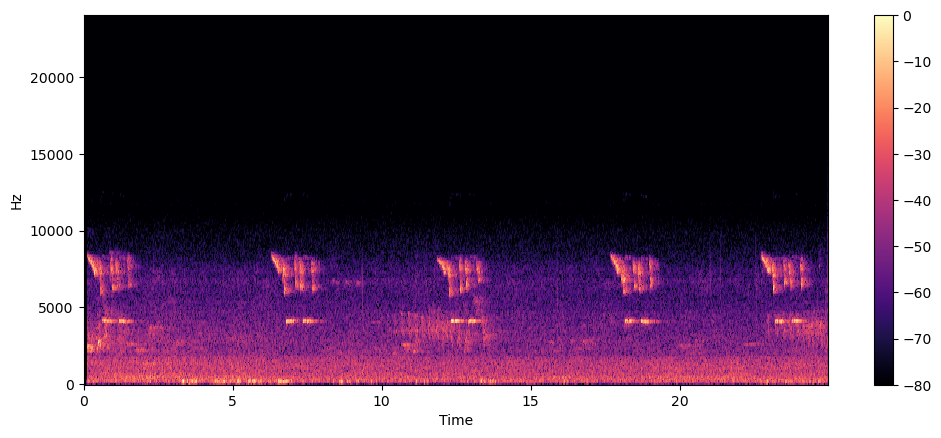

In [120]:
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz", sr=48000)
plt.colorbar()

In [117]:
D_abs = np.abs(D)
D_max = np.max(D_abs)
D_normalized = D_abs / D_max
col_means = np.mean(D_normalized, axis=0)
row_means = np.mean(D_normalized, axis=1)
mask = (D_normalized >= 3 * col_means) & (D_normalized >= 3 * row_means[:, np.newaxis])
masked_D = np.where(mask, 1, 0)
be = binary_erosion(masked_D).astype(masked_D.dtype)
bd = binary_dilation(be)
ind_vec = np.where(np.any(bd, axis=0), 1, 0)
ind_vec = binary_dilation(binary_dilation(ind_vec).astype(ind_vec.dtype))

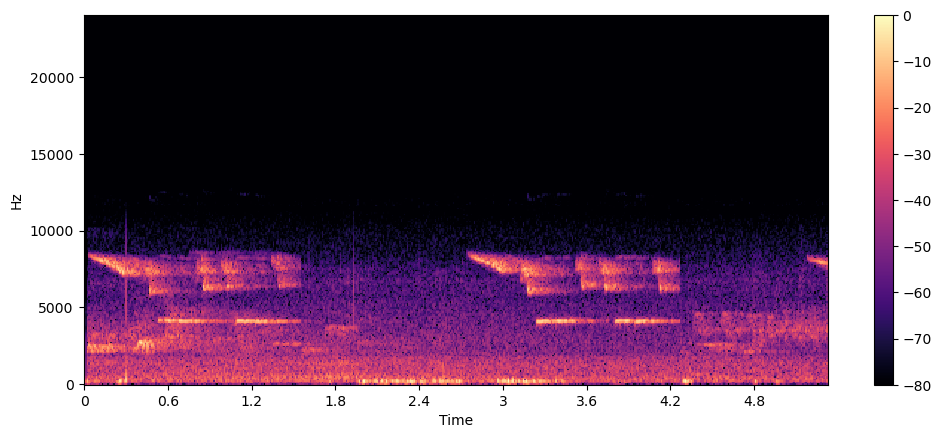

In [136]:
S_db = librosa.amplitude_to_db(D_abs[:, ind_vec][:, :500], ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz", sr=48000)
plt.colorbar()

In [137]:
np.save('test', S_db)